In [ ]:
import numpy as np
import pandas as pd
import cv2
import sys
import os
from sklearn import preprocessing
import tensorflow as tf

from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
from keras.preprocessing import image
from keras.optimizers import SGD

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

from IPython.display import Image

from google.colab.patches import cv2_imshow

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Data/fer2013/fer2013.csv")

features, labels, batch_size = 64, 7, 128
epochs = 150
width, height = 48, 48

# Seperating training and testing set 
X_train, Y_train, X_test, Y_test = [], [], [], []

for i, row in data.iterrows():
    value = row['pixels'].split(" ")

    try:
      if row["Usage"] == "Training":
        X_train.append(np.array(value,'float32'))
        Y_train.append(row['emotion'])
      elif row["Usage"] == "PublicTest":
        X_test.append(np.array(value,'float32'))
        Y_test.append(row['emotion'])   
    except:
      print(f"Error occured at index :{i} and row:{row}")

# Converting array to numpy array for fast processing
X_train = np.array(X_train,'float32')
Y_train = np.array(Y_train,'float32')
X_test = np.array(X_test, 'float32')
Y_test = np.array(Y_test, 'float32')

# Converting to categorical 
Y_train = np_utils.to_categorical(Y_train, num_classes = labels)
Y_test = np_utils.to_categorical(Y_test, num_classes = labels)

# Feature Scaling Data
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

# Reshaping Data
X_train = X_train.reshape(X_train.shape[0], width, height, 1)
X_test = X_test.reshape(X_test.shape[0], width, height, 1)

# Convolutional Neural Network

model = Sequential()

# Layer 1

model.add(Conv2D(features, kernel_size = (3, 3), activation = 'relu', input_shape = (X_train.shape[1:])))
model.add(Conv2D(features, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2, 2)))
model.add(Dropout(0.5))

# Layer 2

model.add(Conv2D(features, kernel_size = (3, 3), activation = 'relu'))
model.add(Conv2D(features, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2, 2)))
model.add(Dropout(0.5))

# Layer 3

model.add(Conv2D(2*features, kernel_size = (3, 3), activation = 'relu'))
model.add(Conv2D(2*features, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2, 2)))

model.add(Flatten())

# Final Layer

model.add(Dense(2*2*2*2*features, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2*2*2*2*features, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(labels, activation = 'softmax'))

#model.summary()

model.compile(loss = categorical_crossentropy, optimizer = Adam(), metrics = ['accuracy'])

model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
          verbose = 1, validation_data = (X_test, Y_test), shuffle = True)

# 28709/64 = 449

json_model = model.to_json()
with open("emotion_rec_model.json", "w") as json_file:
    json_file.write(json_model)
model.save_weights("EmotionRecognition.h5")

Epoch 1/10
28709/28709 [==============================] - 888s 31ms/step - loss: 1.8197 - accuracy: 0.2518 - val_loss: 1.8166 - val_accuracy: 0.2494
Epoch 2/10
28709/28709 [==============================] - 859s 30ms/step - loss: 1.8097 - accuracy: 0.2522 - val_loss: 1.8172 - val_accuracy: 0.2494
Epoch 3/10
28709/28709 [==============================] - 854s 30ms/step - loss: 1.8178 - accuracy: 0.2476 - val_loss: 1.8134 - val_accuracy: 0.2494
Epoch 4/10
28687/28709 [============================>.] - ETA: 0s - loss: 1.8123 - accuracy: 0.2549Buffered data was truncated after reaching the output size limit.

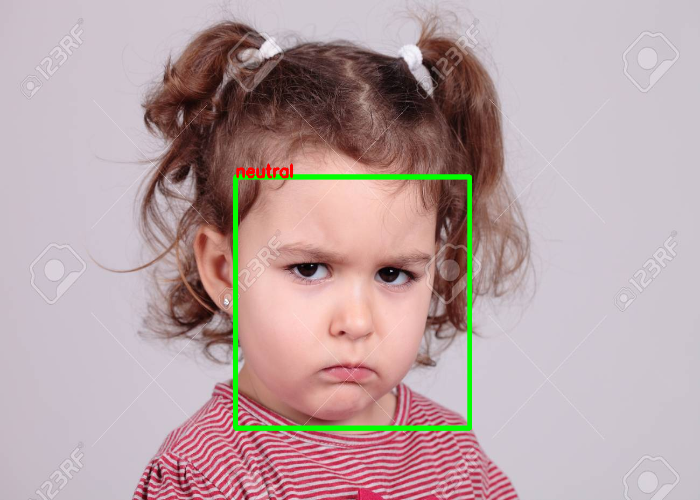

In [ ]:
#model = model_from_json(open("/content/emotion_rec_model.json", "r").read())
#model.load_weights("/content/EmotionRecognition.h5")

#model = model_from_json(open("/content/drive/MyDrive/Data/fer.json", "r").read())
#model.load_weights("/content/drive/MyDrive/Data/fer.h5")

cascade_classifier = cv2.CascadeClassifier("/content/drive/MyDrive/Data/harcascade_frontalface_default.xml")

#cap = cv2.VideoCapture(0)
#ret, img = cap.read()

camFlag = False

if camFlag:
  try:
    realtime_image = take_photo()
    print('Saved to {}'.format(realtime_image))
    display(Image(realtime_image))
    img = cv2.imread(realtime_image)
  except Exception as err:
    print(str(err))
else: 
  img = cv2.imread('/content/drive/MyDrive/Test_Images/Angry_girl.jpg')

gray_img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces_detected = cascade_classifier.detectMultiScale(gray_img, 1.32, 5)

for (x,y,w,h) in faces_detected:
    # Draw rectangles
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), thickness = 7)

    # Get region of interest
    roi = gray_img[y:y+w, x:x+h]

    # Resize image
    roi = cv2.resize(roi,(48,48))

    img_pixels = image.img_to_array(roi)
    img_pixels = np.expand_dims(img_pixels, axis = 0)
    img_pixels /= 255

    predictions = model.predict(img_pixels)

    max_index = np.argmax(predictions[0])

    emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    predicted_emotion = emotions[max_index]

    cv2.putText(img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 3)

if not camFlag: img = cv2.resize(img, (700,500))
cv2_imshow(img)